In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft
from scipy import stats
from scipy.signal import get_window
import glob
import time
def ffts(ys): #the imput are 2d arrays bc this function computes multiple ffts
    Ys = fft.fft(ys, axis = 1) 
    
    return Ys


def filtering_func(freqs, fft, f1, f2): #passing 2D complex numbers
    filtered_fft = fft.copy() #in this way it doesn't reference to fft

    fft_in_range = np.abs(fft[:, (freqs >= f1) & (freqs <= f2) | (freqs >= -f2) & (freqs <= -f1)])
    print(f'fft_in_range: {fft_in_range}')

    #average the rows
    fft_in_range = np.mean(fft_in_range, axis = 0)

    peak = np.max(fft_in_range)

    peak_indices = np.where(fft_in_range == peak)[0]
    print(f"peak_indices: {peak_indices}")

    print(f"fft[peak_indices]: {fft_in_range[peak_indices]}")

    peak_f = freqs[(freqs >= f1) & (freqs <= f2) | (freqs >= -f2) & (freqs <= -f1)][peak_indices]
    print(f"peak_f: {peak_f}")

    fft_in_range[peak_indices] = np.nan
    range_avg = np.nanmean(fft_in_range) #compute the mean excluding the point you are filtering
    print(f'range_avg: {range_avg}')

    print(f'sum: {np.sum(np.isin(freqs, peak_f))}')
    a, b = filtered_fft.shape
    row_indices = np.arange(a).reshape(-1, 1)
    filtered_fft[row_indices, np.isin(freqs, peak_f)] = complex(range_avg, 0)
    return filtered_fft

In [39]:
hour = '15.42'
day = '08082024'

In [40]:
file_pattern = f"../../Waveforms/{day}/{day}_{hour}/{day}_{hour}_wf.csv/{day}_{hour}_wf_*.csv"
file_list = glob.glob(file_pattern)

amplitudes_list = []


if not file_list:
    print("No files found for the given pattern.")
else:
    for i, file in enumerate(file_list):
        df = pd.read_csv(file)
        if i == 0:
            print(df.iloc[:, 0])
            print(df.iloc[:, 1])
            times = pd.to_numeric(df.iloc[1:, 0], errors = 'coerce').values
        amplitudes = pd.to_numeric(df.iloc[1:, 1], errors='coerce').values
        amplitudes_list.append(amplitudes)
        
all_amplitudes = np.stack(amplitudes_list, axis = 0)
N = len(times)
print(f"len(times): {N}")

0               (us)
1         0.00000000
2         0.00080000
3         0.00160000
4         0.00240000
            ...     
62500    49.99920067
62501    50.00000067
62502    50.00080067
62503    50.00160067
62504    50.00240067
Name: Time, Length: 62505, dtype: object
0               (mV)
1        -1.96850400
2        -1.57480300
3        -1.18110200
4        -0.78740150
            ...     
62500     0.00000000
62501     0.39370070
62502    -0.39370070
62503    -1.18110200
62504    -1.18110200
Name: Channel D, Length: 62505, dtype: object
len(times): 62504


## FFT

In [41]:
span = times[-1]
print(f"span: {span}") 
f_s = len(times) / span
print(f"f_s = {f_s}")
freqs = fft.fftfreq(all_amplitudes.shape[1], 1/f_s) #window lenght, sample spacing
print(f'last freq: {freqs[-1]}') ##this should be the half of f_s.
print(f"len(freqs): {len(freqs)}")
print(freqs)

span: 50.00240067
f_s = 1250.0199822905822
last freq: -0.019999039778103515
len(freqs): 62504
[ 0.          0.01999904  0.03999808 ... -0.05999712 -0.03999808
 -0.01999904]


In [42]:
Ys = ffts(all_amplitudes)

In [73]:
if (N%2 == 0):
    pos_freqs = freqs[:round((N/2))]
    pos_Ys = Ys[:, :round((N/2))]
    pos_all_amplitudes = all_amplitudes[:, :round((N/2))]
else:
    pos_freqs = freqs[:round((N-1)/2 + 1)]
    pos_magnitudes = Ys[:, :round((N-1)/2 + 1)]
    pos_all_amplitudes = all_amplitudes[:, :round((N-1)/2 + 1)]

In [104]:
avg_fft = np.mean(np.abs(pos_Ys), axis = 0) 
n = np.max(avg_fft)
avg_fft_au = avg_fft / n

avg_fft_complete = np.mean(np.abs(Ys), axis = 0) 
n = np.max(avg_fft_complete)

freqs_shifted = fft.fftshift(freqs)
avg_fft_complete_au = fft.fftshift(avg_fft_complete) / n

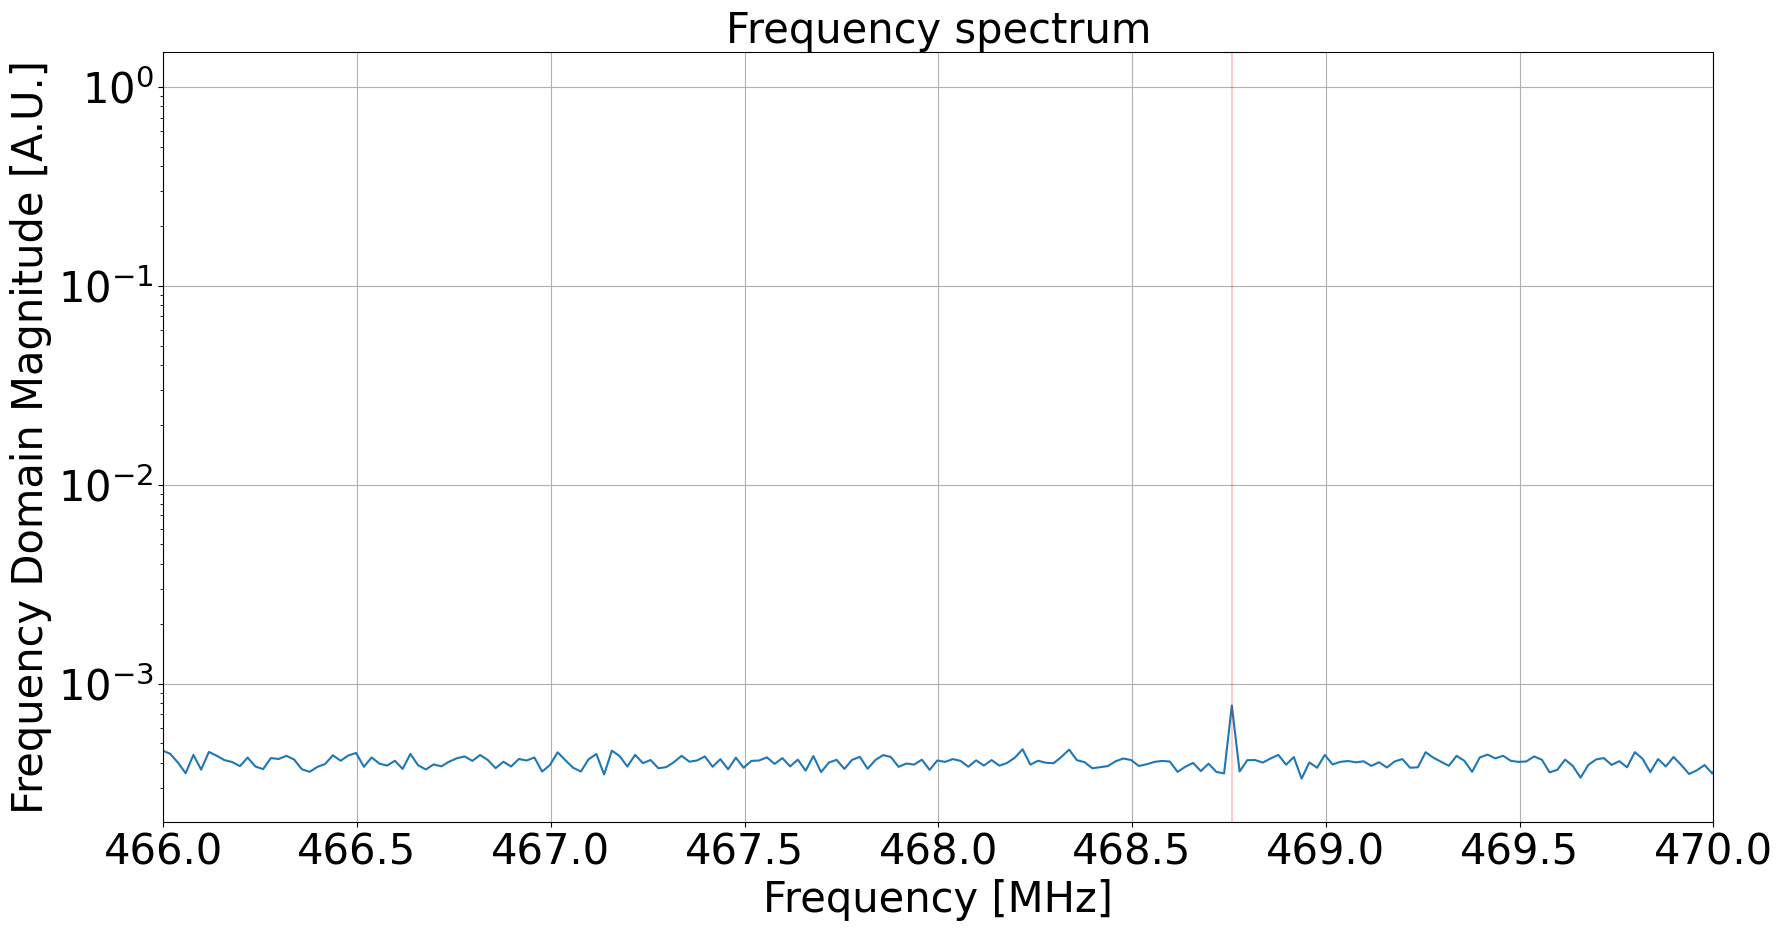

In [45]:
f1 = 466
f2 = 470

plt.figure(figsize=(20, 10))
#plt.errorbar(freqs, avg_fft_au, yerr = stds_fft, fmt='o', markersize = 2, ecolor='red', capsize = 3, capthick=1, elinewidth=1)
plt.plot(pos_freqs, avg_fft_au)

plt.axvline(468.75749336, color = 'red', alpha = 0.2)
plt.title('Frequency spectrum', fontsize = 30)
plt.xlabel('Frequency [MHz]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Frequency Domain Magnitude [A.U.]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.semilogy()
plt.xlim(f1, f2)
plt.grid(True)
#plt.semilogx()

#plt.savefig("250724_17.23/fft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

## Filtering

In [105]:
filtered_fft = filtering_func(freqs, Ys, f1, f2)
if (N%2 == 0):
    pos_filtered_fft = filtered_fft[:, :round((N/2))]
else:
    pos_filtered_fft = filtered_fft[:, :round((N-1)/2 + 1)]

filtered_fft_au = np.mean(np.abs(pos_filtered_fft), axis = 0) / n
filtered_fft_complete_au = fft.fftshift(np.mean(np.abs(filtered_fft), axis = 0)) / n

fft_in_range: [[14.69700282 32.32187938  9.89488511 ...  9.89488511 32.32187938
  14.69700282]
 [41.72466729 37.91984758 37.27513498 ... 37.27513498 37.91984758
  41.72466729]
 [15.52722507 48.46717645 21.33407692 ... 21.33407692 48.46717645
  15.52722507]
 ...
 [16.68504543 59.10667423 26.01006781 ... 26.01006781 59.10667423
  16.68504543]
 [41.00300808 65.47626681 40.15021553 ... 40.15021553 65.47626681
  41.00300808]
 [35.42290617 18.65317787 42.46807637 ... 42.46807637 18.65317787
  35.42290617]]
peak_indices: [137 262]
fft[peak_indices]: [82.67416241 82.67416241]
peak_f: [ 468.75749336 -468.75749336]
range_avg: 42.861280217079674
sum: 2


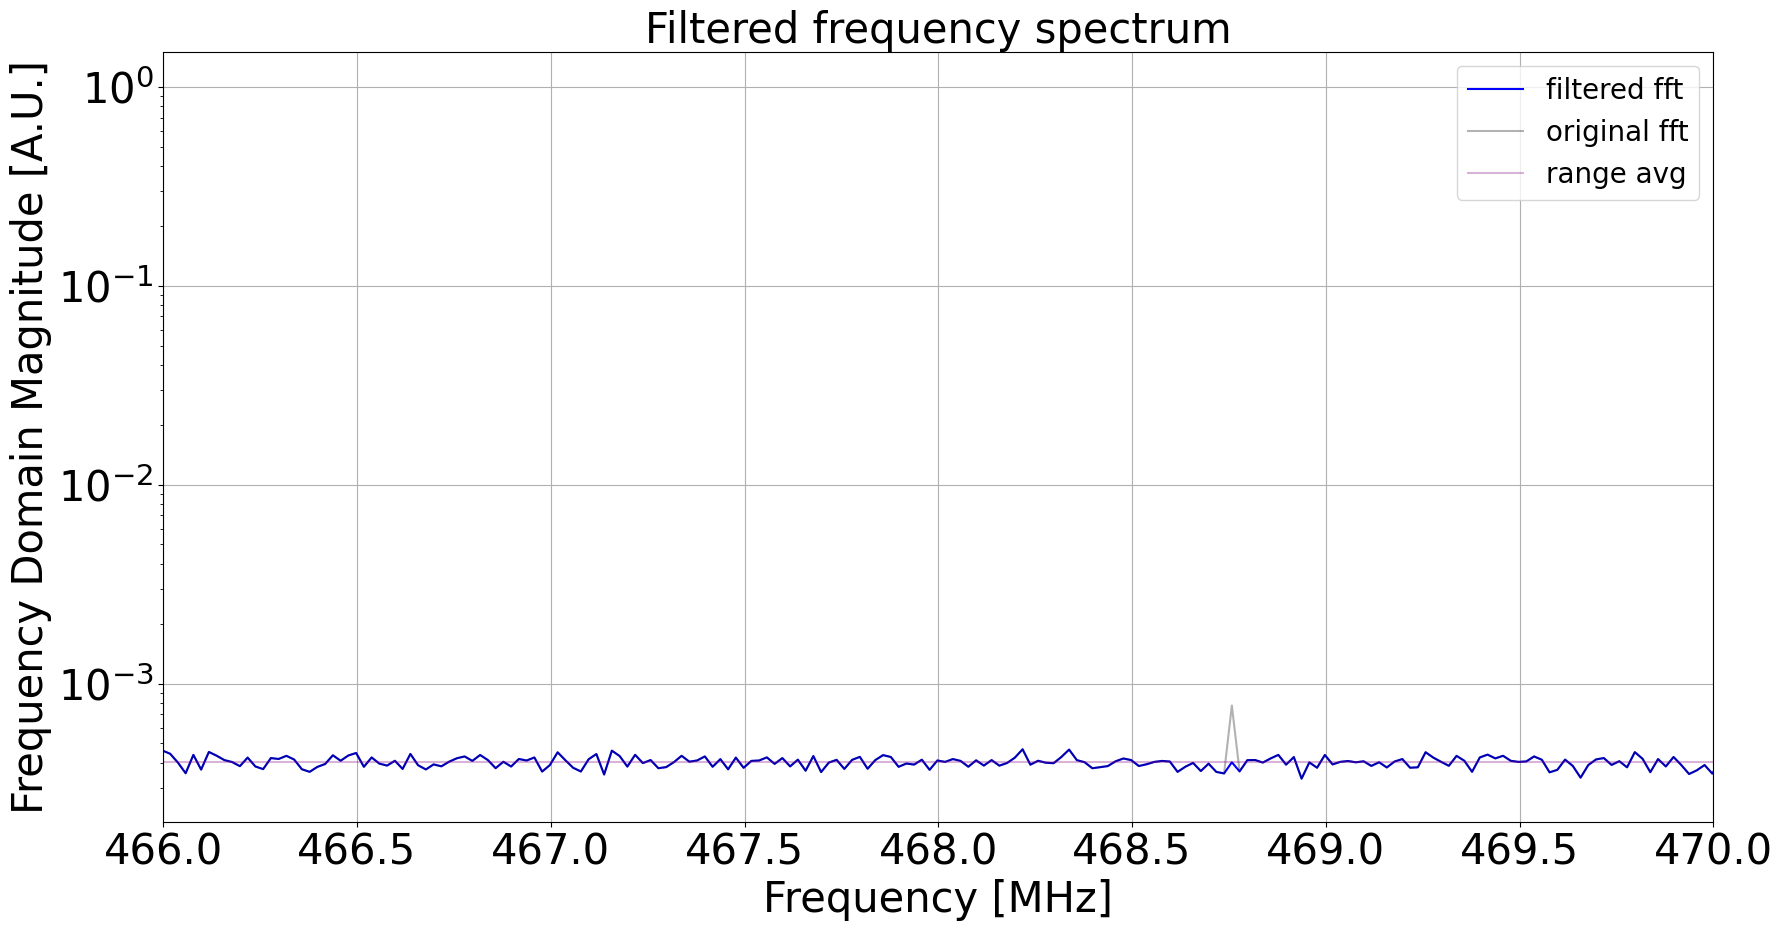

In [106]:
plt.figure(figsize=(20, 10))
#plt.errorbar(freqs, avg_fft_au, yerr = stds_fft, fmt='o', markersize = 2, ecolor='red', capsize = 3, capthick=1, elinewidth=1)
plt.plot(pos_freqs, filtered_fft_au, color = 'blue', label = 'filtered fft')
plt.plot(pos_freqs, avg_fft_au, alpha = 0.3, color = 'k', label = 'original fft')
plt.axhline( 42.861280217079674 / n, color = 'purple', alpha = 0.3, label = 'range avg')

#plt.axvline(465.97762683, color = 'red')
plt.title('Filtered frequency spectrum', fontsize = 30)
plt.xlabel('Frequency [MHz]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Frequency Domain Magnitude [A.U.]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.grid(True)
plt.semilogy()

plt.xlim(f1, f2)
plt.legend(loc = 'best', fontsize = 20)
#plt.semilogx()

#plt.savefig("250724_17.23/fft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

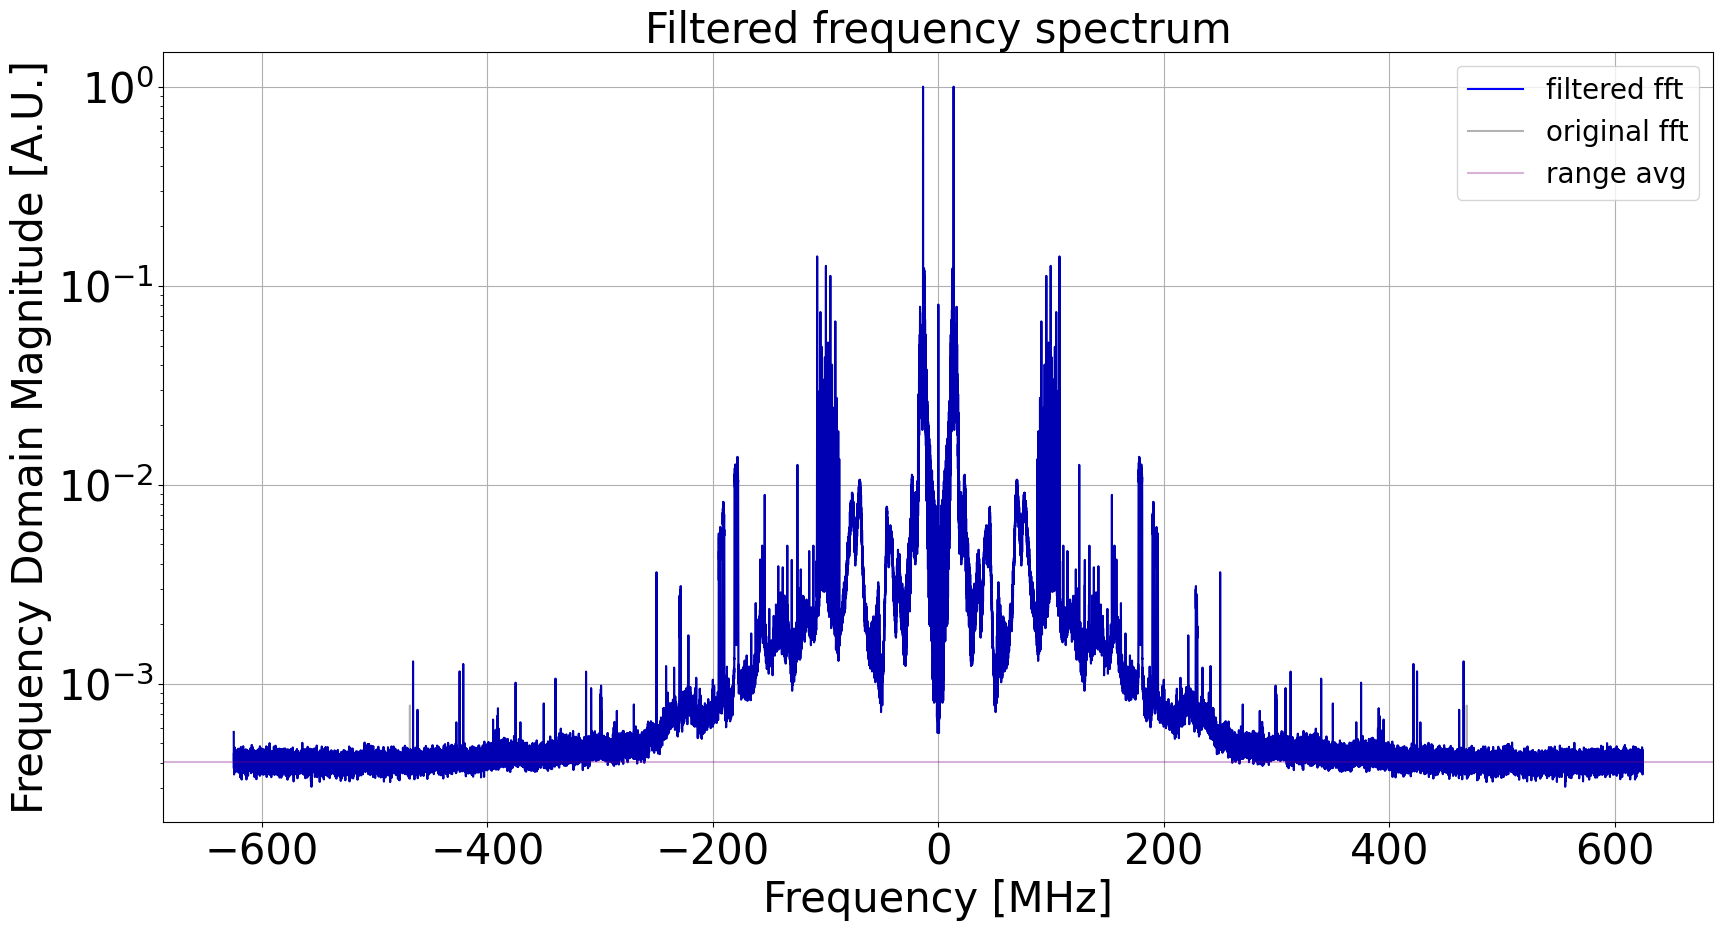

In [108]:
plt.figure(figsize=(20, 10))
#plt.errorbar(freqs, avg_fft_au, yerr = stds_fft, fmt='o', markersize = 2, ecolor='red', capsize = 3, capthick=1, elinewidth=1)
plt.plot(freqs_shifted, filtered_fft_complete_au, color = 'blue', label = 'filtered fft')
plt.plot(freqs_shifted, avg_fft_complete_au, alpha = 0.3, color = 'k', label = 'original fft')
plt.axhline( 42.861280217079674 / n, color = 'purple', alpha = 0.3, label = 'range avg')

#plt.axvline(465.97762683, color = 'red')
plt.title('Filtered frequency spectrum', fontsize = 30)
plt.xlabel('Frequency [MHz]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Frequency Domain Magnitude [A.U.]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.grid(True)
plt.semilogy()

#plt.xlim(-f2, -f1)
plt.legend(loc = 'best', fontsize = 20)
#plt.semilogx()

#plt.savefig("250724_17.23/fft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

## IFFT

In [125]:
#times_ifft = np.arange(N) / f_s #SAME as times, just checking
filtered_amplitudes = fft.ifft(filtered_fft, axis = 1) #input/output = 2D complex array
avg_filtered_amplitudes = np.mean(filtered_amplitudes.real, axis = 0)

## Compare to reconstructed waveform

In [126]:
reconstructed_wf = fft.ifft(Ys, axis = 1)
avg_reconstructed_wf = np.mean(reconstructed_wf.real, axis = 0)

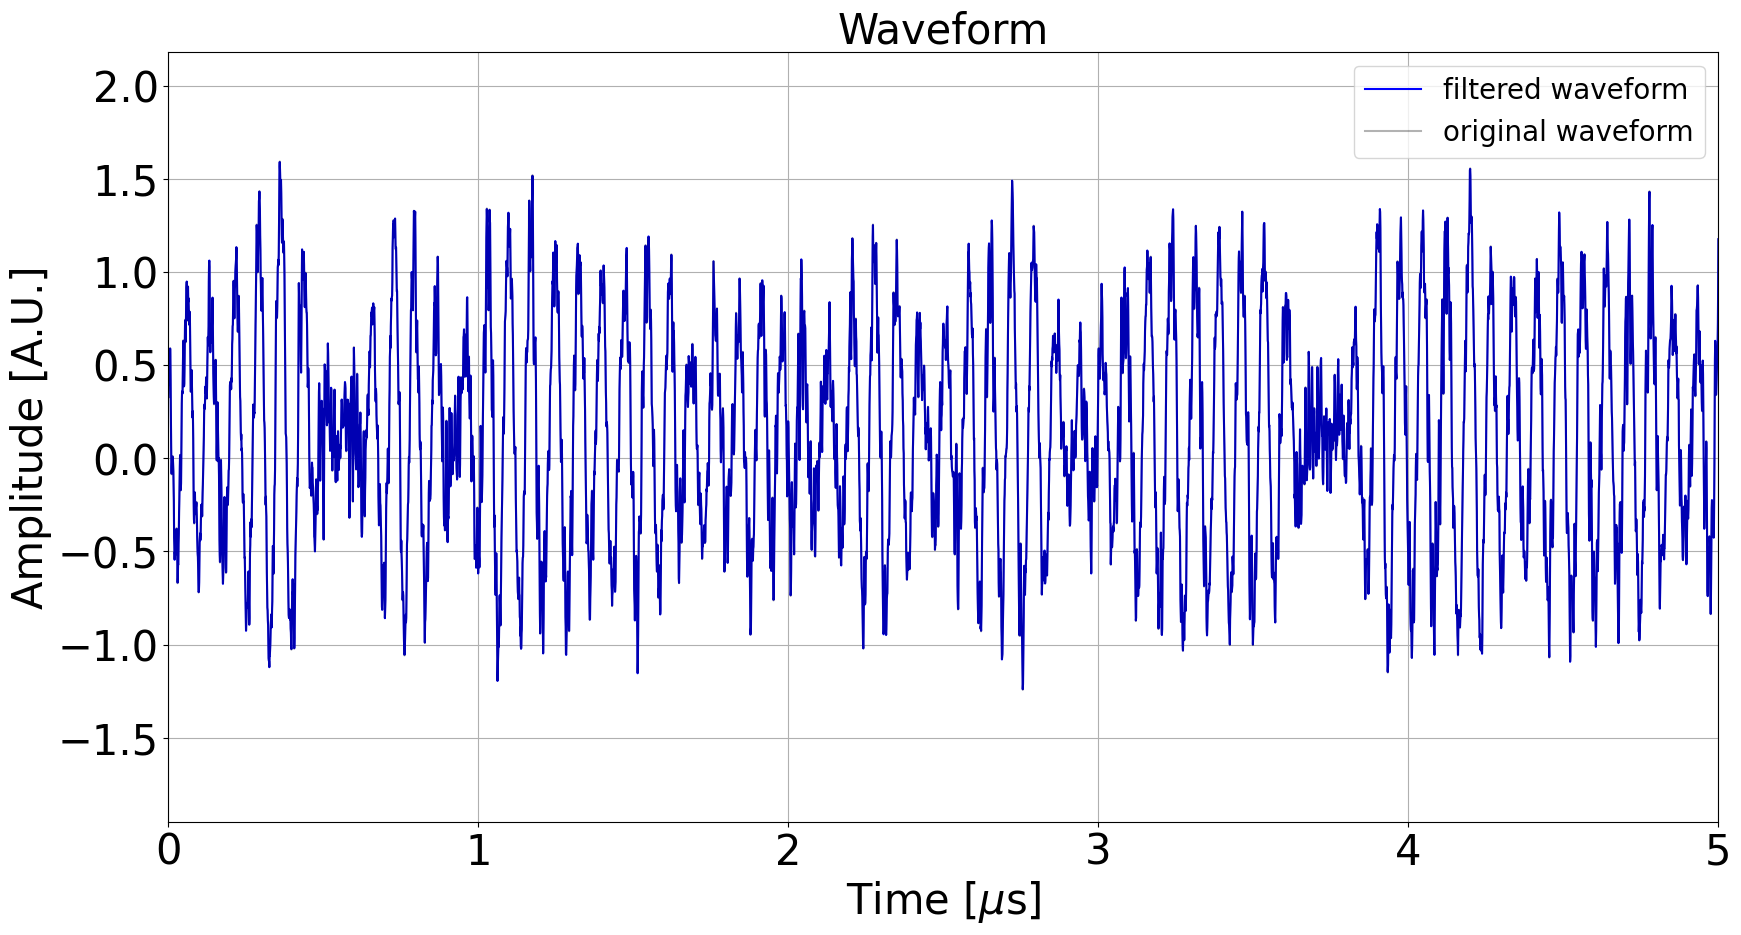

In [127]:
plt.figure(figsize = (20, 10))
plt.plot(times, avg_filtered_amplitudes, label = 'filtered waveform', color = 'blue')
plt.plot(times, avg_reconstructed_wf, label = 'original waveform', color = 'k', alpha = 0.3)
plt.title('Waveform', fontsize = 30)
plt.xlabel(r'Time [$\mu$s]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Amplitude [A.U.]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.grid(True)
plt.xlim(0, 5)
plt.legend(loc = 'best', fontsize = 20)

#plt.savefig("Results/simple_ifft.png", format = "png", bbox_inches="tight")
#plt.savefig("Results/simple_ifft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

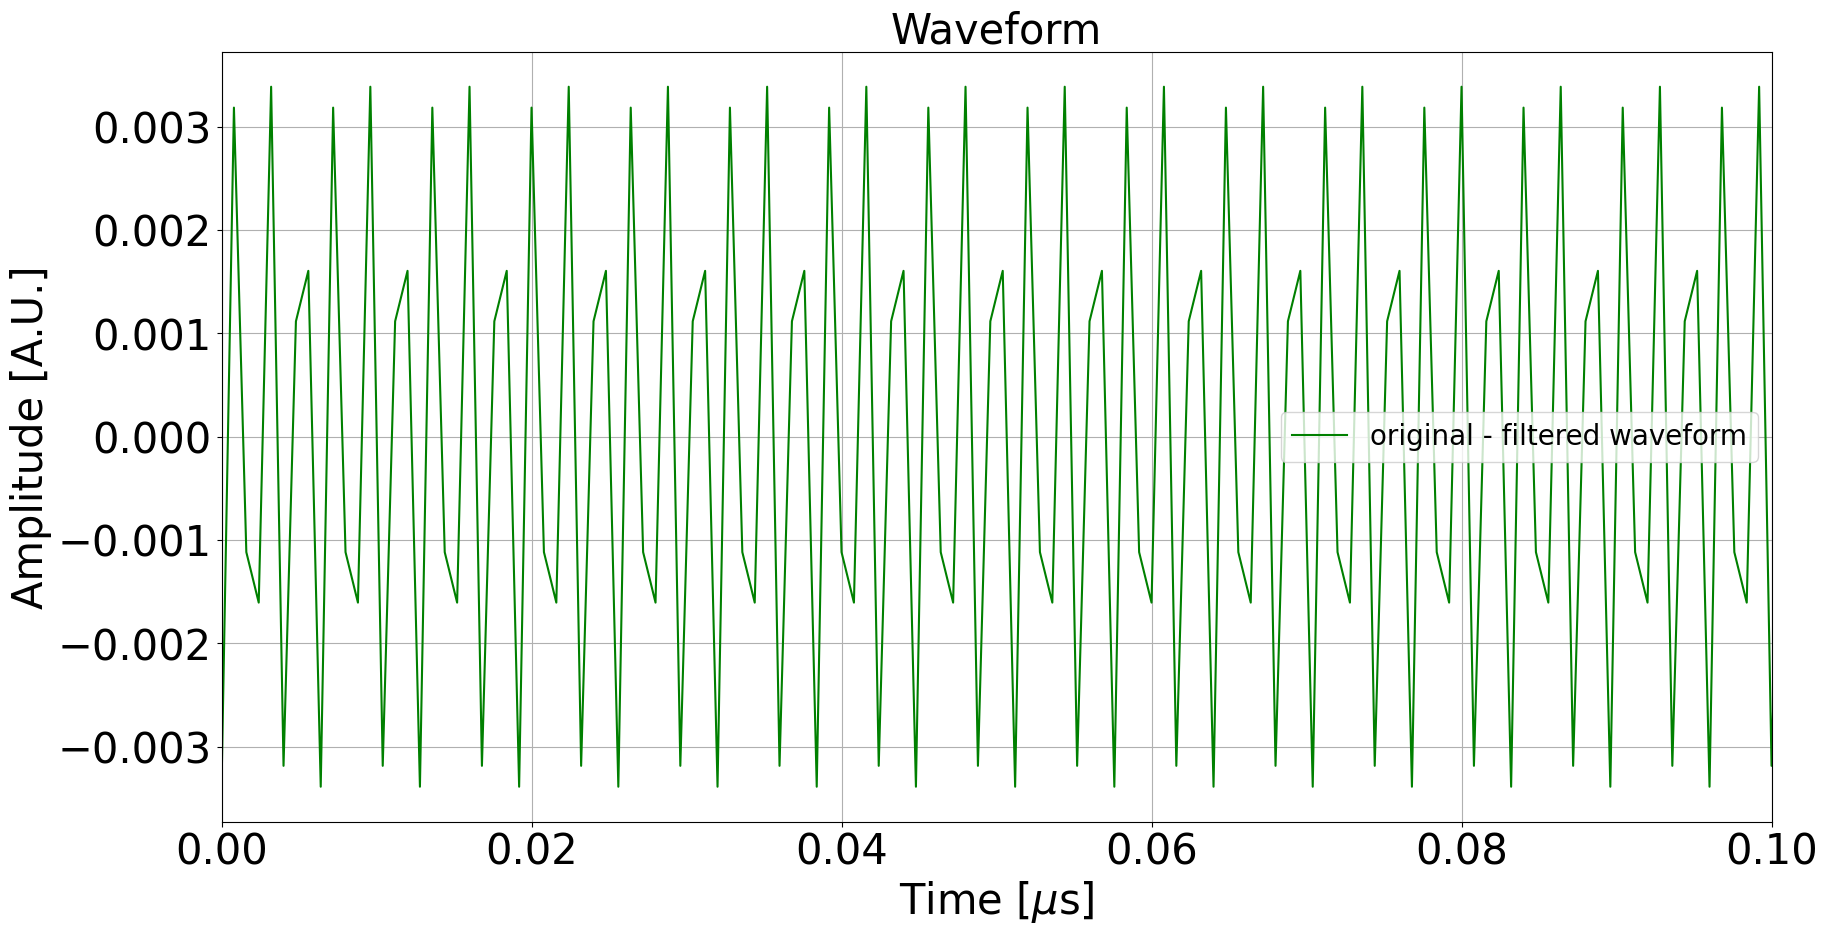

In [128]:
plt.figure(figsize = (20, 10))
plt.plot(times, avg_reconstructed_wf - avg_filtered_amplitudes, label = 'original - filtered waveform', color = 'green')
plt.title('Waveform', fontsize = 30)
plt.xlabel(r'Time [$\mu$s]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Amplitude [A.U.]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.grid(True)
plt.xlim(0, 0.1)
plt.legend(loc = 'best', fontsize = 20)

#plt.savefig("Results/simple_ifft.png", format = "png", bbox_inches="tight")
#plt.savefig("Results/simple_ifft.pdf", format = "pdf", bbox_inches="tight")
plt.show()